In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, CustomJS, Select
from bokeh.plotting import figure,show
from bokeh.layouts import column
from bokeh.io import curdoc, output_notebook
from matplotlib import rcParams
import graphs_pollutants_max_daily
import lightgbm as lgb
output_notebook()

Loading BokehJS ...

In [2]:
pollutants = pd.read_csv("pollutants_aggregated.csv")
pollutants = pollutants.sort_values("date")

In [3]:
pollutants.head()

,date,id_parameter,mean_value,max_value,min_value,hour,weekday
207,2017-01-01 00:00:00,CO,0.870370,2.0,0.1,0,6
209,2017-01-01 00:00:00,NO2,36.458333,65.0,11.0,0,6
210,2017-01-01 00:00:00,NOX,56.541667,163.0,12.0,0,6
211,2017-01-01 00:00:00,O3,11.764706,46.0,1.0,0,6
212,2017-01-01 00:00:00,PM10,46.526316,128.0,12.0,0,6


## *Pollution in Mexico City*

#### Justification:

Mexico City is one of the most polluted cities in the world, this has a very negative impact in the health and the quality of life of its citizens. 

Even in pandemic times, there were some days when the air pollution reached a very dangerous peak. 

The government has stablished some limitations about driving certain plate colors certain days a week in order to reduce the air pollution, but these kind of regulations seem to be not enough. 

Because of that I propose this project, to find new insights with data from many sources to understand human bevaior (on daily basis), weather and their impact in the air pollution, with the objective to predict peaks in air pollution and if it is possible to propose to get new policies or stimulus that mitigate the amount of pollutants in the air.

The objectives of this project are:
- To understand the behavior of pollution along the time and its components and identify patterns and variables that has an impact in the airpollution.
- Get insights from basic to complex data.
- Understand the relation among human behavior (on daily basis)and weather in the pollutant in the air.
- Make predictable models about the levels of air pollution.
- Propose solutions (policies, stimulus).

#### Data
* Pollutants in the air per datetime and zones in Mexico City.
* Daily weather in Mexico City.
* Daily afluency of metro passengers.

#### Data in the future
* I have requested the data for the afluency of metrobus passengers.

#### Let's begin checking the data

**Important dates:**


* 2021-06-08, environmental alert by O3 high levels (+150)
* 2021-04-26, environmental alert by O3 high levels (+150)
* 2021-04-21, environmental alert by O3 high levels (+150)
* 2020-11-11, environmental alert by O3 high levels (+150)
* 2019-12-25, environmental alert by PM25 high levels (+150)
* 2019-05-14, environmental alert by PM25 high levels (+160)
* 2019-05-14, environmental alert by O3 high levels (+140)
* 2019-04-16, environmental alert by O3 high levels (+150)
* 2019-04-10, environmental alert by O3 high levels (+150)
* 2019-03-30, environmental alert by O3 high levels (+150)
* 2019-01-01, environmental alert by PM10 high levels (+150)
* 2018-12-25, environmental alert by PM10 high levels (+150)
* 2018-06-06, environmental alert by O3 high levels (+160)
* 2017-12-14, environmental alert by PM10 high levels (+150)
* 2017-05-22, environmental alert by O3 high levels (+160)
* 2017-05-17, environmental alert by O3 high levels (+160)
* 2017-01-06, environmental alert by PM10 high levels (+150)

#### Units of measurements of pollutants
* CO: mg/m
* NO: ppb
* NO2: ppb
* NOX: ppb
* O3: ppb
* PM10: $\mu$g/m
* PM2.5: $\mu$g/m
* PMCO: $\mu$g/m
* SO2: ppb

In [4]:
max_poll_day = pollutants[:]
max_poll_day["date"] = pd.to_datetime(max_poll_day.date)
max_poll_day["date"] = max_poll_day["date"].dt.date
max_poll_day = max_poll_day.groupby(["date", "id_parameter"])["max_value"].agg([("max_value_per_day", np.max)]).reset_index()

#### Pollutants along the time

* Mostly all of the pollutants reduced their presence in the air in 2020 (maybe because the start of the pandemic).

In [5]:
show(graphs_pollutants_max_daily.graph(max_poll_day))

#### Pollutants behavior along the day

* The hours with the highest peak during a day are between 8:00 and 12:00 and 10:00 and 16:00.

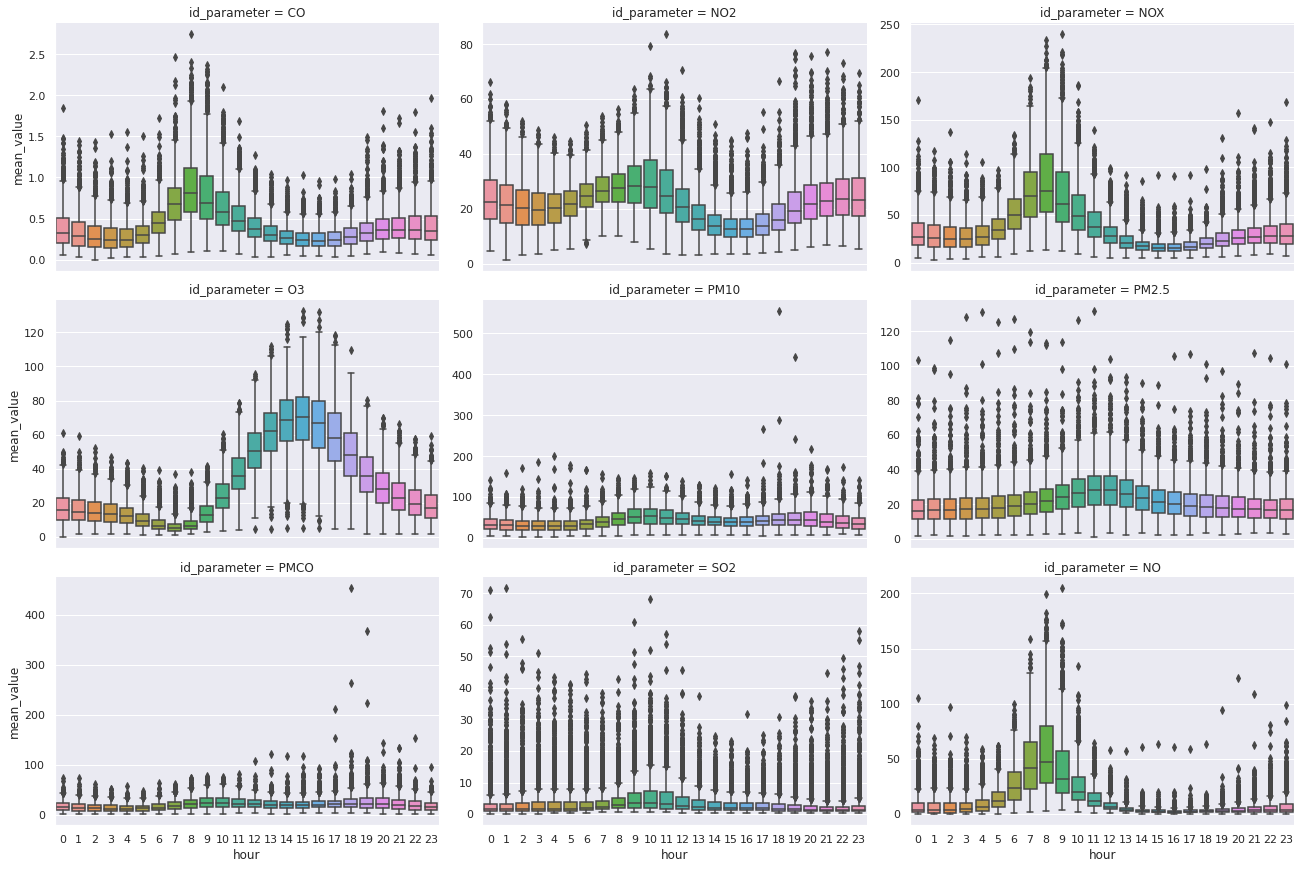

In [6]:
sns.catplot(data=pollutants, x='hour', y='mean_value',
            col='id_parameter', kind='box', col_wrap=3,  height=4, aspect=1.5, sharey=False)

#### Pollutants behavior along the weekdays
* Weekends show the less presence of pollutants for almost all of the pollutants but for PMCO.

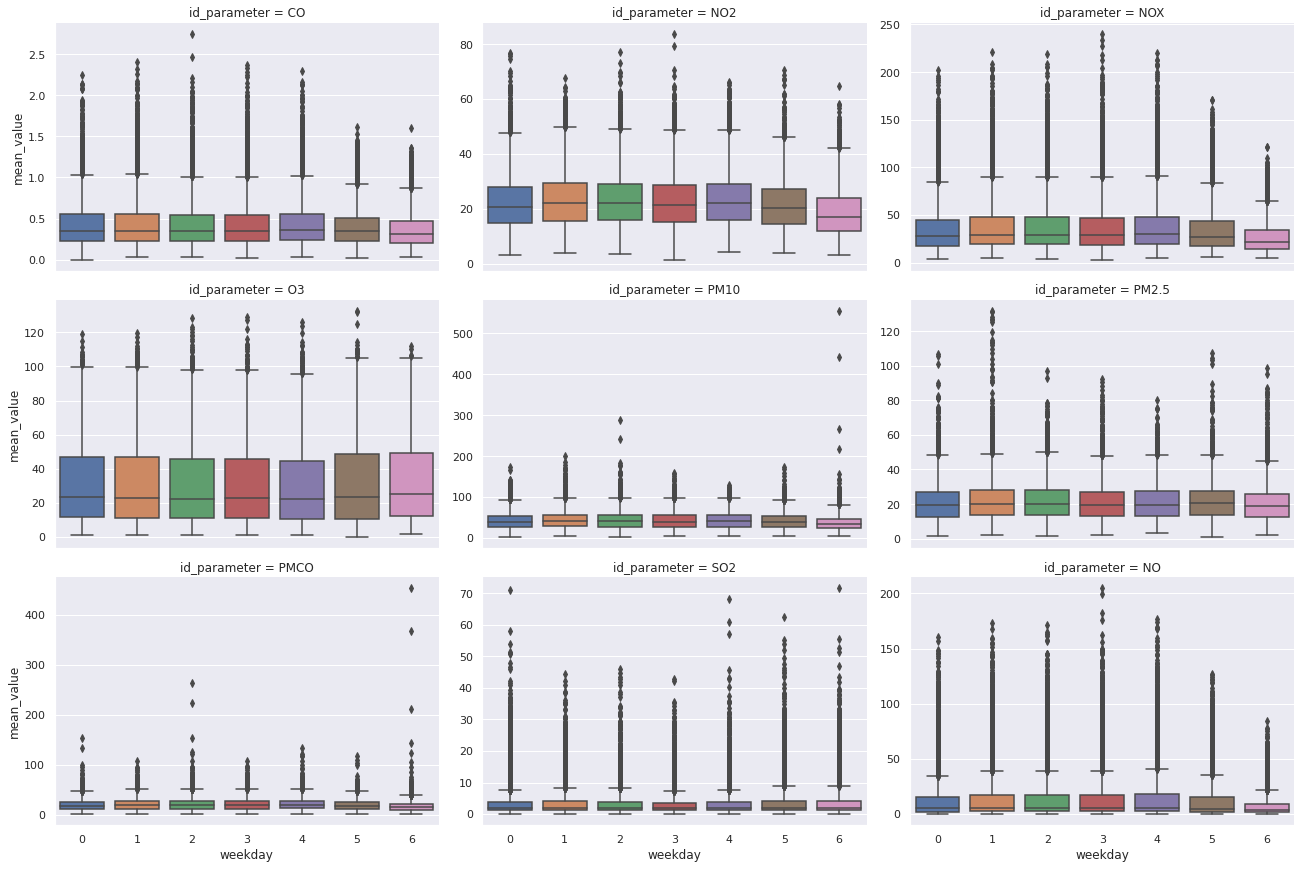

In [7]:
sns.catplot(data=pollutants, x='weekday', y='mean_value',
            col='id_parameter', kind='box', col_wrap=3,  height=4, aspect=1.5, sharey=False)

#### Weather

* I do not feel comfortable saying that weather has experience some changes along the time in Mexico City, because I need mor historical data to make a good opinion about the subject.

In [8]:
weather = pd.read_csv("weather.csv")
weather = weather.rename(columns = {"DATE":"date"})
weather.date = pd.to_datetime(weather.date)
weather.date = weather.date.dt.date
weather["celsius"] = (weather.TAVG - 32)*5/9

In [9]:
graph = figure(title = "Average Weather", x_axis_type="datetime", plot_width=900, plot_height=400)
graph.xaxis.axis_label = "Date"
graph.yaxis.axis_label = "Celsius degrees"
line_color = "red"  
line_dash_offset = 1
graph.line(weather.date, 
           weather.celsius,
           line_color = line_color,
           line_dash_offset = line_dash_offset)

show(graph)

#### Metro Afluency

In [10]:
metro = pd.read_csv("metro.csv", low_memory=False)
metro["date"] = pd.to_datetime(metro.fecha)
metro.date = metro.date.dt.date
metro.afluencia = metro.afluencia.str.replace(",", "").replace("-", "").replace(".0","").replace(' -   ',"")
metro.afluencia = metro.afluencia.fillna(0)
metro.afluencia = np.where(metro.afluencia == "", 0, metro.afluencia)
metro.afluencia = metro.afluencia.astype(float)
metro_daily = metro.groupby(["date"])["afluencia"].agg([("afluencia", np.sum)]).reset_index()

#### Correlation among the variables

* There are some strong positive correlation among NOX, NO2, NO, CO. This could be give us evidence that this pollutants came from similar sources
* There are a moderate positive correlation among Small Particles (PM10, PM2.5, PMCO) and  NOX, NO2, NO, CO.
* There are some strong positive correlation among Small Particles. This could be give us evidence that this pollutants came from similar sources.
* Weather has some possitive correlation with PM10, O3 and negative correlation with SO2 and also with the afluency of metro passengers.
* Metro passengers has some positive correlation with NOX, NO2, NO and CO.


**That is a good news, because we have different data from pollutants that could explain the behavior of pollution in the air**

Text(0.5, 1.0, "Heatmap Pollutants, Weather And Metro's Afluency")

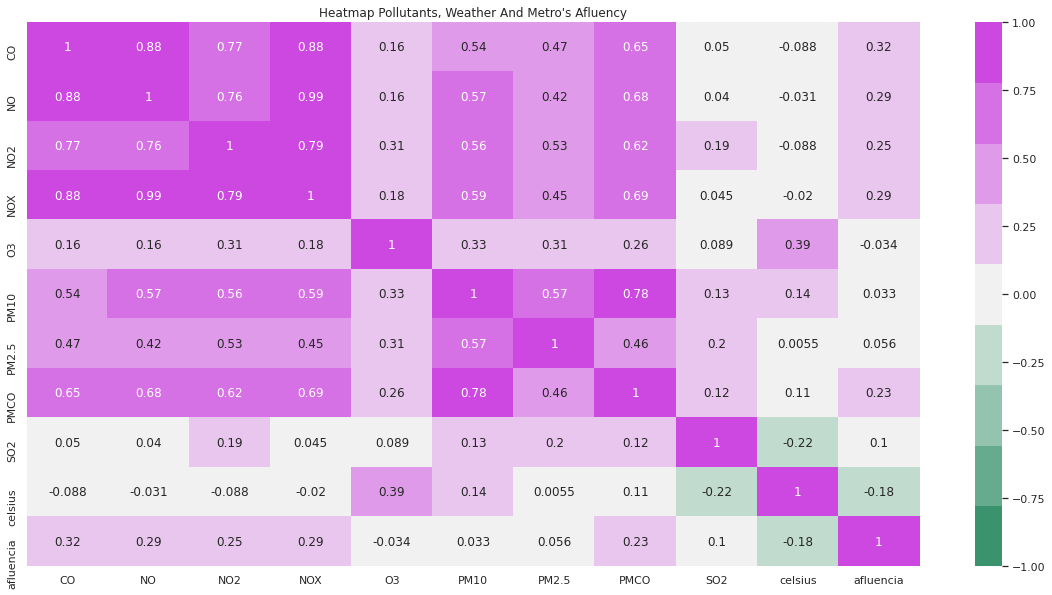

In [11]:
### I will summarize the number of particles per day just to see if there is correlation with
cmap =sns.diverging_palette(150, 300, s=80, l=55, n=9)
rcParams['figure.figsize'] = 20,10

pollutants_perday = pd.pivot_table(max_poll_day, values='max_value_per_day', index=['date'],
                                   columns=['id_parameter'], aggfunc=np.mean, fill_value=0).reset_index()
pollutants_perday = pollutants_perday.merge(weather, on="date", how= "inner")
pollutants_perday = pollutants_perday.merge(metro_daily, on = ["date"], how="left")

sns.heatmap(pollutants_perday[['CO', 'NO', 'NO2', 'NOX', 'O3', 
                               'PM10', 'PM2.5', 'PMCO','SO2','celsius', "afluencia"]].corr(),
           vmin=-1, vmax=1, annot=True, cmap = cmap).set_title("Heatmap Pollutants, Weather And Metro's Afluency")


#### Make some predictions

**In order to have a baseline I created an Average of the last 4 weeks to predict the day peaks of all of the pollutants in the air between 2021-08-25 and 2021-08-31.**

**Also, I created a very simple model using lightgbm to predict the the day peaks at the same week.**

**Some limitations**
* y variable is the max value by pollutant registered in the city.

This is because 2 reasons:
* I cannot match yet the geographical data for metro stations and meteorological stations.
* I have just the daily weather.

#### Average last 4 Weeks for prediction

In [12]:
max_poll_day.date = pd.to_datetime(max_poll_day.date)
max_poll_day["weekday"] = max_poll_day.date.dt.weekday
last_4weeks = max_poll_day[(max_poll_day.date >= "2021-07-28") & (max_poll_day.date <'2021-08-25')]
last_4weeks = last_4weeks.groupby(["weekday", 
                                   "id_parameter"])["max_value_per_day"].agg([("avg_last_4weeks",
                                                                               np.mean)]).reset_index()

daydir = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
last_4weeks.weekday = last_4weeks.weekday.map(daydir)

#### A basic model for prediction

In [13]:
def treatment(df, weather, metro):
    df.date = pd.to_datetime(df.date)
    weather.date = pd.to_datetime(weather.date)
    metro.date = pd.to_datetime(metro.date)

    df = df.merge(weather, on=["date"], how = "left")
    weather["weekday"] = weather.date.dt.weekday

    avg_weather_day = weather.groupby("weekday")["celsius"].agg([("weather_mean", np.mean)]).reset_index()
    df["weekday"] = df.date.dt.weekday
    df = df.merge(avg_weather_day, on="weekday", how="left")
    df["celsius"] = np.where(df.celsius.isnull(), df.weather_mean, df.celsius)
    df = df.sort_values(["id_parameter", "date"], ascending=True)
    df["value_last_1week"] = df.groupby(["id_parameter"])["max_value_per_day"].shift(7)
    df["value_last_2week"] = df.groupby(["id_parameter"])["max_value_per_day"].shift(14)
    df["value_last_3week"] = df.groupby(["id_parameter"])["max_value_per_day"].shift(21)
    df["value_last_4week"] = df.groupby(["id_parameter"])["max_value_per_day"].shift(28)
    metro = metro.groupby("date")["afluencia"].agg([("afluencia", np.sum)]).reset_index()
    df = df.merge(metro, on="date", how="left")
    metro["weekday"] = metro.date.dt.weekday
    avg_metro_day = metro.groupby("weekday")["afluencia"].agg([("afluencia_mean", np.mean)]).reset_index()
    df = df.merge(avg_metro_day, on="weekday", how="left")
    df["afluencia"] = np.where(df.afluencia.isnull(), df.afluencia_mean, df.afluencia)
    df["afluencia_last_1week"] = df.groupby(["id_parameter"])["afluencia"].shift(7)
    df["afluencia_last_2week"] = df.groupby(["id_parameter"])["afluencia"].shift(14)
    df["afluencia_last_3week"] = df.groupby(["id_parameter"])["afluencia"].shift(21)
    df["afluencia_last_4week"] = df.groupby(["id_parameter"])["afluencia"].shift(28)    
    
    df = df.dropna(axis = 0, subset = ["value_last_1week", "value_last_2week", 
                                       "value_last_3week", "value_last_4week"])
    
    t = df[["date"]].drop_duplicates()
    t["time"] = np.arange(0, t.date.nunique())
    df = df.merge(t, on="date", how="left")
    daydir = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df.weekday = df.weekday.map(daydir)
    one_hot_day = pd.get_dummies(df.weekday)
    df = pd.concat([df, one_hot_day], axis=1)
    
    x_train = df[df.date < '2021-08-25']
    x_test = df[(df.date >= '2021-08-25')]
    
    norm = x_train.groupby("id_parameter")["max_value_per_day"].agg([("mean_val", np.mean), 
                                                               ("std_val", np.std)]).reset_index()
    
    x_train = x_train.merge(norm, on="id_parameter", how="left")
    x_test = x_test.merge(norm, on="id_parameter", how="left")
    
    
    x_train["value"] = (x_train.max_value_per_day - x_train.mean_val)/x_train.std_val
    x_test["value"] = (x_test.max_value_per_day - x_test.mean_val)/x_test.std_val
    x_train["value_last_1week"] = (x_train.value_last_1week - x_train.mean_val)/x_train.std_val
    x_test["value_last_1week"] = (x_test.value_last_1week - x_test.mean_val)/x_test.std_val
    x_train["value_last_2week"] = (x_train.value_last_2week - x_train.mean_val)/x_train.std_val
    x_test["value_last_2week"] = (x_test.value_last_2week - x_test.mean_val)/x_test.std_val
    x_train["value_last_3week"] = (x_train.value_last_3week - x_train.mean_val)/x_train.std_val
    x_test["value_last_3week"] = (x_test.value_last_3week - x_test.mean_val)/x_test.std_val
    x_train["value_last_4week"] = (x_train.value_last_4week - x_train.mean_val)/x_train.std_val
    x_test["value_last_4week"] = (x_test.value_last_4week - x_test.mean_val)/x_test.std_val
    x_train["value_mean_last_4week"] = (x_train.value_last_1week + x_train.value_last_2week + x_train.value_last_3week + x_train.value_last_4week)/4
    x_test["value_mean_last_4week"] = (x_test.value_last_1week + x_test.value_last_2week + x_test.value_last_3week + x_test.value_last_4week)/4
    
    afluencia_mean, afluencia_std = x_train.afluencia.mean(), x_train.afluencia.std()
    
    x_train.afluencia = (x_train.afluencia - afluencia_mean)/afluencia_std
    x_test.afluencia =  (x_test.afluencia - afluencia_mean)/afluencia_std
    x_train["afluencia_last_1week"] = (x_train.afluencia_last_1week - afluencia_mean)/afluencia_std
    x_test["afluencia_last_1week"] = (x_test.afluencia_last_1week - afluencia_mean)/afluencia_std
    x_train["afluencia_last_2week"] = (x_train.afluencia_last_2week - afluencia_mean)/afluencia_std
    x_test["afluencia_last_2week"] = (x_test.afluencia_last_2week - afluencia_mean)/afluencia_std
    x_train["afluencia_last_3week"] = (x_train.afluencia_last_3week - afluencia_mean)/afluencia_std
    x_test["afluencia_last_3week"] = (x_test.afluencia_last_3week - afluencia_mean)/afluencia_std
    x_train["afluencia_last_4week"] = (x_train.afluencia_last_4week - afluencia_mean)/afluencia_std
    x_test["afluencia_last_4week"] = (x_test.afluencia_last_4week - afluencia_mean)/afluencia_std
    x_train["afluencia_mean_last_4week"] = (x_train.afluencia_last_1week + x_train.afluencia_last_2week + x_train.afluencia_last_3week + x_train.afluencia_last_4week)/4
    x_test["afluencia_mean_last_4week"] = (x_test.afluencia_last_1week + x_test.afluencia_last_2week + x_test.afluencia_last_3week + x_test.afluencia_last_4week)/4
    
    
    weather_mean, weather_std = x_train.celsius.mean(), x_train.celsius.std()
    
    x_train.celsius = (x_train.celsius - weather_mean)/weather_std
    x_test.celsius =  (x_test.celsius - weather_mean)/weather_std
    
    val_per_day = x_train.groupby(["id_parameter", "weekday"])["value"].agg([("val_mean_day", np.mean),
                                                                            ("val_std_day", np.std)])
    
    x_train = x_train.merge(val_per_day, on = ["id_parameter", "weekday"], how = "left")
    x_test = x_test.merge(val_per_day, on = ["id_parameter", "weekday"], how = "left")

    return x_train, x_test, norm

In [14]:
x_train, x_test, norm = treatment(max_poll_day, weather, metro)
ytrain = x_train.value 
ytest = x_test.value
columns = ['value_last_1week', 'value_last_2week','value_last_3week', 'value_last_4week', 
           'afluencia_last_1week', 'afluencia_last_2week', 'afluencia_last_3week', 
           'afluencia_last_4week', 'time', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 
           'Tuesday', 'Wednesday', 'value_mean_last_4week', 'afluencia_mean_last_4week', 'val_mean_day',
           'val_std_day','celsius']

Xtrain = x_train[columns]
Xtest = x_test[columns]

#### RMSE for test data of lgbm prediction 

In [15]:
parameter = [{"leaves": 20, "lambda1": 1.2, "learn": 0.3, "estim": 700}]
    # lightgbm model
    # train the first week
for param in parameter:
    gbm = lgb.LGBMRegressor(objective='regression',
                            num_leaves=param["leaves"],
                            lambda_l1=param["lambda1"],
                            boosting="dart",
                            learning_rate=param["learn"],
                            n_estimators=param["estim"])
    gbm.fit(Xtrain, ytrain)
    
y_hat = gbm.predict(Xtest)
x_test["prediction"] = (y_hat*x_test.std_val) + x_test.mean_val
results = x_test[["id_parameter","max_value_per_day", "prediction"]]
results["square_error"] = (results.max_value_per_day - results.prediction)**2
results = results.groupby("id_parameter")["square_error"].agg([("MSE", np.mean)]).reset_index()
results["RMSE"] = np.sqrt(results.MSE)

results[["id_parameter", "RMSE"]]
    

/home/cosmicfox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,id_parameter,RMSE
0,CO,0.350930
1,NO,25.719830
2,NO2,11.705168
3,NOX,28.343158
4,O3,22.170661
5,PM10,18.942658
6,PM2.5,8.477787
7,PMCO,32.138582
8,SO2,7.219981


#### Comparison Real value vs baseline vs lgbm

Text(0.5, 1.0, 'PMCO Real vs Prediction')

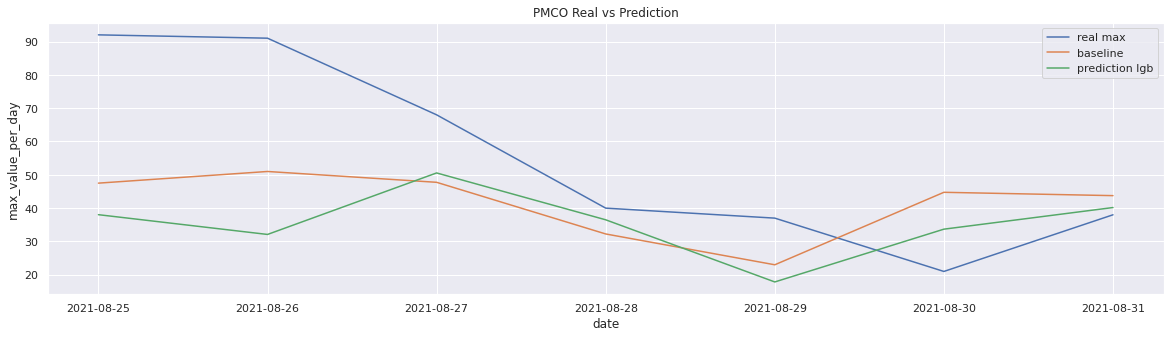

In [16]:
x_test["prediction"] = (y_hat*x_test.std_val) + x_test.mean_val
results = x_test[["date", "weekday","id_parameter","max_value_per_day", "prediction"]]
results = results.merge(last_4weeks, on=["weekday", "id_parameter"], how="left")
rcParams['figure.figsize'] = 20,5

sns.lineplot(x = "date", y = "max_value_per_day",data=results[results.id_parameter=="PMCO"], label="real max")
sns.lineplot(x = "date", y = "avg_last_4weeks",data=results[results.id_parameter=="PMCO"], label="baseline")
sns.lineplot(x = "date", y = "prediction",data=results[results.id_parameter=="PMCO"], 
             label="prediction lgb").set_title("PMCO Real vs Prediction")

Text(0.5, 1.0, 'SO2 Real vs Prediction')

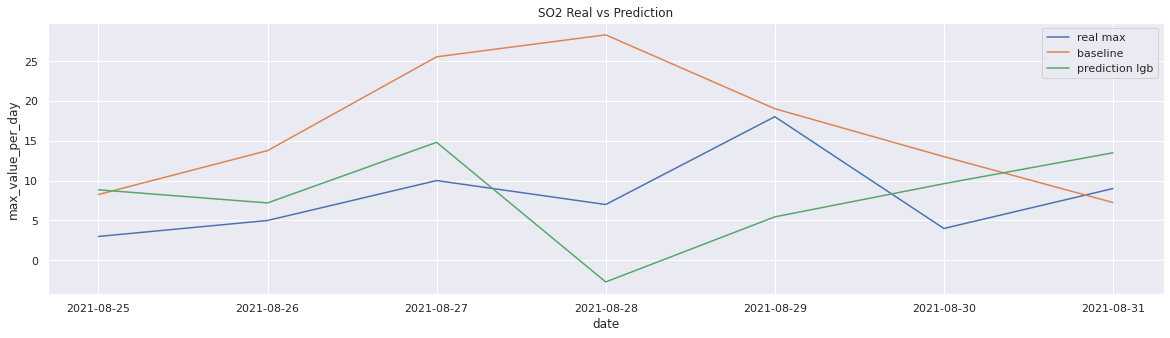

In [17]:
sns.lineplot(x = "date", y = "max_value_per_day",data=results[results.id_parameter=="SO2"],  label="real max")
sns.lineplot(x = "date", y = "avg_last_4weeks",data=results[results.id_parameter=="SO2"], label="baseline")
sns.lineplot(x = "date", y = "prediction",data=results[results.id_parameter=="SO2"],  
             label="prediction lgb").set_title("SO2 Real vs Prediction")

Text(0.5, 1.0, 'O3 Real vs Prediction')

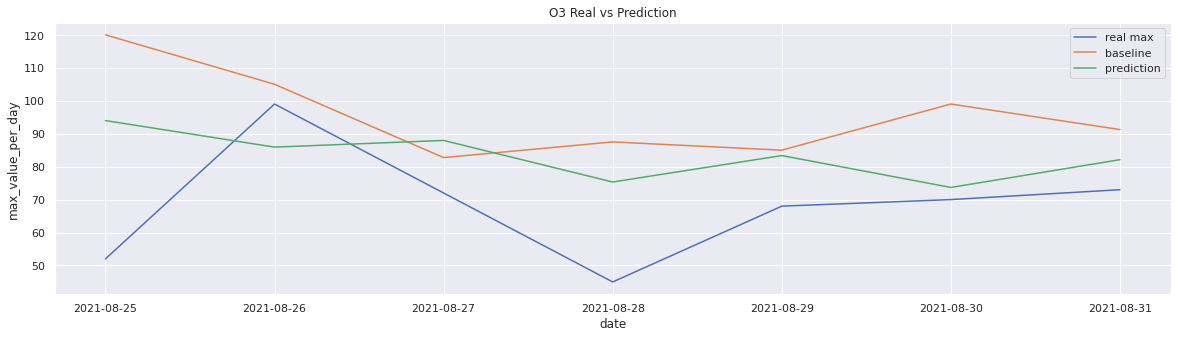

In [18]:
sns.lineplot(x = "date", y = "max_value_per_day",data=results[results.id_parameter=="O3"],  label="real max")
sns.lineplot(x = "date", y = "avg_last_4weeks",data=results[results.id_parameter=="O3"], label="baseline")
sns.lineplot(x = "date", y = "prediction",data=results[results.id_parameter=="O3"],
             label="prediction").set_title("O3 Real vs Prediction")

Text(0.5, 1.0, 'PM10 Real vs Prediction')

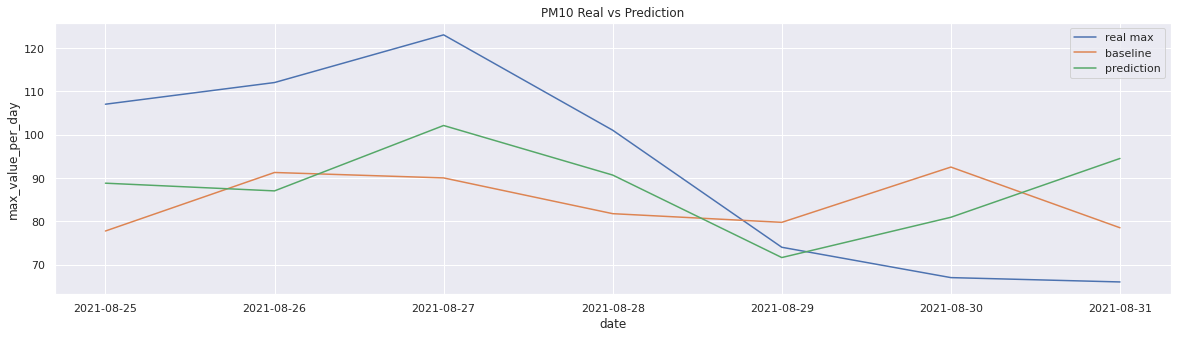

In [19]:
sns.lineplot(x = "date", y = "max_value_per_day",data=results[results.id_parameter=="PM10"],  label="real max")
sns.lineplot(x = "date", y = "avg_last_4weeks",data=results[results.id_parameter=="PM10"], label="baseline")
sns.lineplot(x = "date", y = "prediction",data=results[results.id_parameter=="PM10"],  
             label="prediction").set_title("PM10 Real vs Prediction")

Text(0.5, 1.0, 'PM2.5 Real vs Prediction')

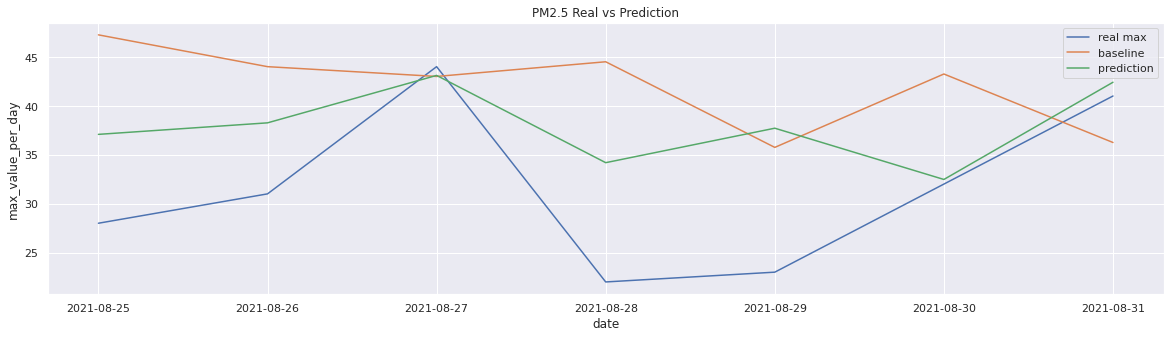

In [20]:
sns.lineplot(x = "date", y = "max_value_per_day",data=results[results.id_parameter=="PM2.5"],  label="real max")
sns.lineplot(x = "date", y = "avg_last_4weeks",data=results[results.id_parameter=="PM2.5"], label="baseline")
sns.lineplot(x = "date", y = "prediction",data=results[results.id_parameter=="PM2.5"],  
             label="prediction").set_title("PM2.5 Real vs Prediction")